In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
# import sys

# sys.path.extend(
#     [
#         'src/poultry',
#     ]
# )

In [4]:
import string
import json
from itertools import chain, islice
from collections import deque

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import pairwise_distances

In [5]:
with open('eval/RTS17/topics.json') as f:
    topics = json.load(f)
topics = [topics[-22], topics[2]]
queries = [t['title'] for t in topics]

In [6]:
qrels = pd.read_csv(
    'eval/RTS17/eval_qrelsfile',
    sep=' ',
    names=['topic', 'q0', 'tweet_id', 'judgment'],
    usecols=['topic', 'tweet_id', 'judgment'],
    header=None,
    index_col=['tweet_id', 'topic'],
    squeeze=True,
).unstack('topic')

qrels = qrels[['RTS212', 'RTS48']]

qrels = pd.concat([qrels], axis=1, keys=['Relevance'])

In [7]:
point = pd.read_csv(
    'eval/RTS17/gundog/ngram-length(3)_keep-spam(0)_language(en)_extract-retweets(0)_keep-retweets(0).point',
    sep=' ',
    names=[
        'topic', 'tweet_id',
        'Distance to query',
        'Distance to positive', 'Distance to negative',
        'Score',
        'retrieve', 'Positive', 'Negative',
    ],
    header=None,
    index_col=['tweet_id', 'topic'],
    squeeze=True,
#     dtype={'Negative': int},
).unstack('topic')

# point = pd.concat([point], axis=1, keys=['Point'])

point = point.merge(
    qrels, how='left',
    left_index=True, right_index=True,
)

/home/dnm11/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
topics = list(point['Relevance'].apply(lambda c: c.value_counts()).dropna(axis='columns', how='all').columns.values)

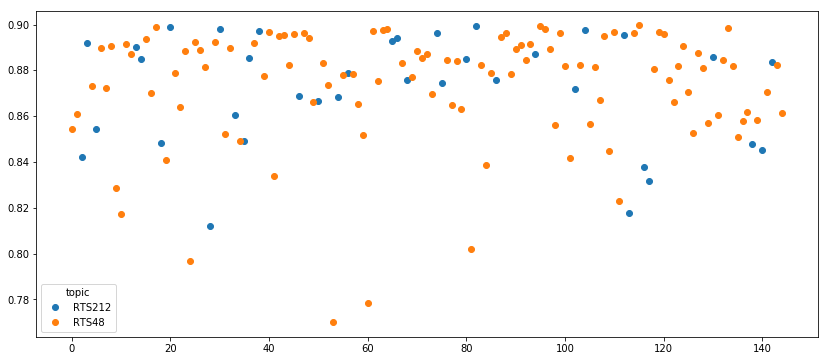

In [9]:
(
    point['Distance to query'][topics]
    .apply(np.vectorize(lambda v: v if v < 0.9 else None)).dropna(how='all')
    .plot(style='o', use_index=False, figsize=(14, 6))
);

In [10]:
point.sort_values(
    [
        ('Score', 'RTS212'),
        ('Score', 'RTS48'),
        ('Relevance', 'RTS212'),
        ('Relevance', 'RTS48'),
    ][0],
    ascending=True,
)[:10]

Distance to query           Distance to positive            \
topic                         RTS212     RTS48               RTS212     RTS48   
tweet_id                                                                        
891189075146792964          0.831737  0.933903             0.831737  0.933903   
891192015345508352          0.902292  1.000000             0.902292  1.000000   
891189968542027776          0.914536  1.000000             0.914536  1.000000   
891199263102971905          0.883805  1.000000             0.883805  1.000000   
891200492033855489          1.000000  1.000000             0.904058  1.000000   
891199879674032129          1.000000  1.000000             0.907173  1.000000   
891200731113549824          0.991065  1.000000             0.921028  1.000000   
891198042573070336          0.848064  0.976537             0.848064  0.976537   
891196209645441026          0.928433  1.000000             0.928433  1.000000   
891190719318294531          0.911145  1.000000             0.911145  1.000000   

                   Distance to negative               Score            \
topic                            RTS212     RTS48    RTS212     RTS48   
tweet_id                                                                
891189075146792964             0.929974  0.978444  0.894367  0.954478   
891192015345508352             0.991269  0.958139  0.910239  1.043690   
891189968542027776             0.996492  1.000000  0.917755  1.000000   
891199263102971905             0.960161  0.982371  0.920475  1.017946   
891200492033855489             0.981782  0.976043  0.920834  1.024545   
891199879674032129             0.982478  1.000000  0.923351  1.000000   
891200731113549824             0.995372  0.988441  0.925310  1.011694   
891198042573070336             0.914555  0.963504  0.927297  1.013526   
891196209645441026             1.000000  1.000000  0.928433  1.000000   
891190719318294531             0.981313  1.000000  0.928496  1.000000   

                   retrieve        Positive       Negative       Relevance  \
topic                RTS212  RTS48   RTS212 RTS48   RTS212 RTS48    RTS212   
tweet_id                                                                     
891189075146792964     True   True      1.0   1.0      1.0   1.0       NaN   
891192015345508352     True  False      1.0   1.0      1.0   1.0       NaN   
891189968542027776     True  False      1.0   1.0      1.0   1.0       NaN   
891199263102971905     True  False      2.0   1.0      1.0   1.0       1.0   
891200492033855489     True  False      2.0   1.0      1.0   2.0       NaN   
891199879674032129     True  False      2.0   1.0      1.0   1.0       NaN   
891200731113549824     True  False      2.0   1.0      1.0   2.0       NaN   
891198042573070336     True  False      1.0   1.0      1.0   1.0       NaN   
891196209645441026     True  False      1.0   1.0      1.0   1.0       NaN   
891190719318294531     True  False      1.0   1.0      1.0   1.0       NaN   

                          
topic              RTS48  
tweet_id                  
891189075146792964   NaN  
891192015345508352   NaN  
891189968542027776   NaN  
891199263102971905   NaN  
891200492033855489   NaN  
891199879674032129   NaN  
891200731113549824   NaN  
891198042573070336   NaN  
891196209645441026   NaN  
891190719318294531   NaN

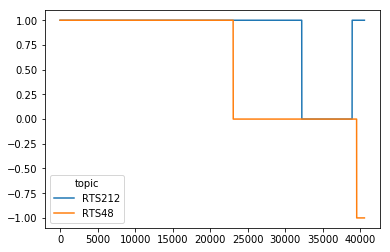

In [11]:
(point['Positive'] - point['Negative'])[topics].plot(use_index=False);

In [12]:
relevance_score_by_topic = point.dropna('rows', how='all', subset=[('Relevance', 'RTS212'), ('Relevance', 'RTS48')]).fillna(-3)

relevance_score_by_topic.columns.names = ['Type', 'Topic']

relevance_score_by_topic = relevance_score_by_topic.stack('Topic').reset_index('Topic')

In [13]:
point['Relevance'].apply(lambda c: c.value_counts()).dropna(axis='columns', how='all').sum()

Topic
RTS212    12.0
RTS48      5.0
dtype: float64

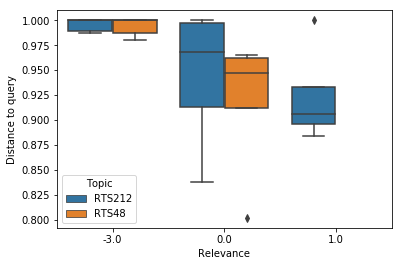

In [14]:
sns.boxplot(data=relevance_score_by_topic, x='Relevance', y='Distance to query', hue='Topic');

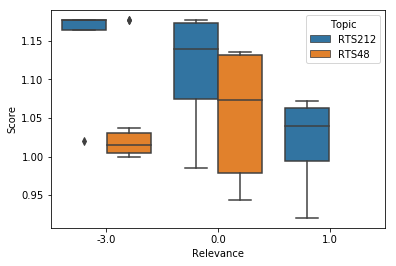

In [15]:
sns.boxplot(data=relevance_score_by_topic, x='Relevance', y='Score', hue='Topic');

In [16]:
# point[['Distance to query', 'Score']].cummin().plot(use_index=False);

In [17]:
# point[['Distance to query', 'Score']].rolling(1_000_000, min_periods=1).min().plot(use_index=False);

In [18]:
point['Distance to query'].corrwith(point['Score'])

Topic
RTS212    0.218738
RTS48     0.230997
dtype: float64